# A tool for dataset comparison: Observational Data at a point location

## Overview

This page contains Python code that can extract and display historical climate data from different sources at a point location for comparison.
The code can be run on the PAVICS platform or a locally configured Python environment with [Jupyter Notebook or Jupyter Lab](https://jupyter.org/) functionality enabled.
It relys on the data available on PAVICS, but other data from other sources may be introduced.

Two versions are shown:

* A simple script that may be modified by the user to control the output figure.
* A script that generates an interactive dashboard with widgets for the user to control the output of the figure.

::: {.callout-warning title="Note"}
The code sections below can not be executed on this web page. For them to be run they will need to be copied to a Jupyter Notebook on PAVICS or a local Python environment.
:::

## A simple script
This script generates a figure to compare datasets of historical climate.

### First we need to import libraries and define the data
The following section determines the content of the figure in terms of the datasets, the point location, the time period and the frequency.

In [1]:
import xarray as xr
import xclim as xc
from xclim.core import units
from clisops.core.subset import subset_gridpoint
import matplotlib.pyplot as plt
from datetime import date
from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings(action='ignore')
# plt.style.available
plt.style.use('seaborn-v0_8')

# Inputs
lat_in = 45.0
lon_in = -72.0

start_date = date(1991,1,1)
end_date = date(2020,12,31)

freq = 'year'

datasets = {
    "ECCC_AHCCD_gen3_temperature": "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen3_temperature.ncml",
    #"ECCC_AHCCD_gen2_precipitation": "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen2_precipitation.ncml",
    "NRCANMet_v2": "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/gridded_obs/nrcan_v2.ncml",
    "RDRSv2.1": "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_RDRSv2.1_NAM.ncml",
    "ERA5-Land": "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_ERA5-Land_NAM.ncml"
    }

def aggregate(ds, var, freq='annual'):
    freqs={
        'month': 'MS',
        'season': 'QS-DEC',
        'year': 'YS'
    }
    functs = {
        'pr': xc.indicators.atmos.precip_average,
        'tasmin': xc.indicators.atmos.tn_mean,
        'tasmax': xc.indicators.atmos.tx_mean,
    }
    return functs[var](ds=ds, freq=freqs[freq])

/exec/braun/.conda/envs/energy-data/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


### In the second step we create the figure
The next section of code will load the data for the selected location, time period, location and frequency and generate the figure.

Error:curl error: Timeout was reached
curl error details: 


OSError: [Errno -68] NetCDF: I/O failure: 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen3_temperature.ncml'

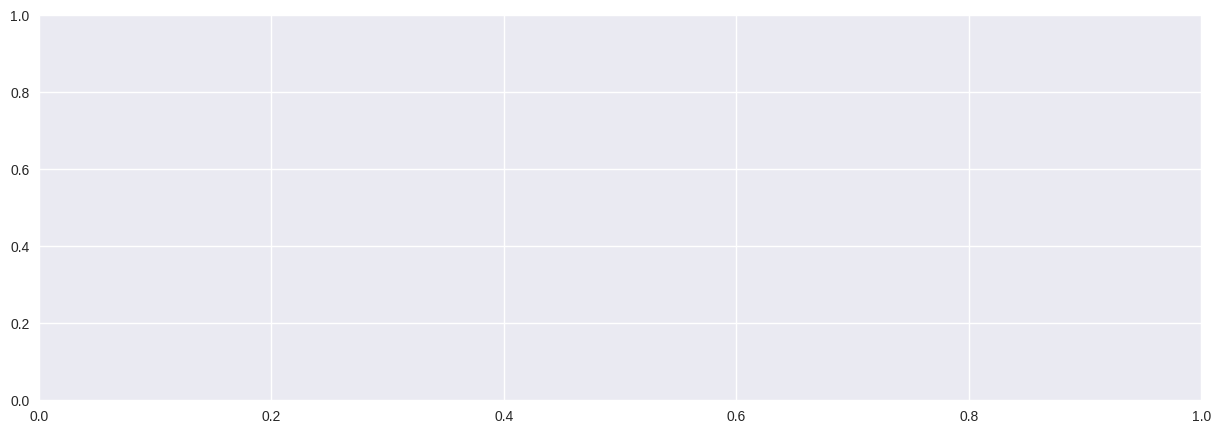

In [2]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
for idx, (name, url) in enumerate(datasets.items()):
    ds = xr.open_dataset(url, chunks={'time': -1, 'lat': 50, 'lon': 50}, decode_timedelta=False)
    print(f"Loading {name} ...") 
    #display(ds) 
    ds_pt = subset_gridpoint(ds,
                             lat=lat_in,
                             lon=lon_in,
                             start_date=start_date.strftime('%Y-%m-%d'),
                             end_date=end_date.strftime('%Y-%m-%d'),
                             add_distance=True)
    
    dist = f"dist = {ds_pt.distance.values/1000:0.1f} km"
    #print(dist)
    
    # Style
    color = f"C{idx}"
    line_styles = {"tasmin": ":", "tasmax": "--"}
    
    tmp_vars = ['tasmin', 'tasmax']
    if all(var in ds.data_vars for var in tmp_vars):
        for var in tmp_vars:

            ds_var = aggregate(ds=ds_pt, var=var, freq=freq)

            if 'units' in ds_var.attrs and ds_var.units == 'K':
                ds_var = units.convert_units_to(ds_var, "degC")
            #display(ds_pt)

            ds_var.plot.line(ax=ax,
                            linestyle=line_styles[var],
                            color=color,
                            label=f"{name} - {dist}" if var == 'tasmin' else None,
                            add_legend=False
                           )
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_ylabel(f"Minimum and maximum\n{freq} temperature [˚C]")
plt.title(f"{freq.capitalize()} Minimum and Maximum Temperatures from Multiple Datasets between {start_date.year} and {end_date.year}");

Modifying the two code sections above allows the user to adjust the content of the figure.

## A script to create an interactive dashboard

### Preparations for the dashboard
The following section of code defines functions that will be used by the dashboard to update the figure based on user input.

In [ ]:
# Callback function to create the Matplotlib plot
def create_plot(xlim, freq, var):
    
    start, end = xlim
    start = date(start,1,1)
    end = date(end,12,31)
    
    fig, ax = plt.subplots(figsize=(9,3))
    
    for idx, (name, file) in enumerate(data_files.items()):
        # Style:
        color = f"C{idx}"
        line_styles = {"tasmin": ":", "tasmax": "--"}

        tmp_vars = ['tasmin', 'tasmax']
        ds = xr.open_dataset(file)
        dist = f"dist = {ds.distance.values/1000:0.1f} km"
        if all(var in ds.data_vars for var in tmp_vars):
            for var in tmp_vars:

                ds_var = aggregate(ds=ds, var=var, freq=freq)

                if 'units' in ds_var.attrs and ds_var.units == 'K':
                    ds_var = units.convert_units_to(ds_var, "degC")
                #display(ds_pt)

                ds_var.sel(time=slice(start, end)).plot.line(ax=ax,
                                linestyle=line_styles[var],
                                linewidth=1,
                                color=color,
                                label=f"{name} - {dist}" if var == 'tasmin' else None,
                                add_legend=False
                               )
    ax.set_ylabel(f"Minimum and maximum\n{freq} temperature [˚C]")
    ax.xaxis.label.set_fontsize(8)  # Update x-axis label font size
    ax.yaxis.label.set_fontsize(8)  # Update y-axis label font size
    ax.tick_params(axis='x', labelsize=6)  # Update x-axis tick labels font size
    ax.tick_params(axis='y', labelsize=6)  # Update y-axis tick labels font size
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=6)
    plt.title(f"{freq.capitalize()} Minimum and Maximum Temperatures from Multiple Datasets between {start.year} and {end.year}", fontsize=8);
    
    plt.close(fig)  # Prevent Matplotlib from displaying the figure immediately
    return fig

# callback function to exract data for point location.
def extract_data(lat, lon):
    
    # ToDo: delete old points data!
    data_files = {}
    for idx, (name, url) in enumerate(datasets.items()):
        ds = xr.open_dataset(url, chunks={'time': -1, 'lat': 50, 'lon': 50}, decode_timedelta=False)
        print(f"{10*'-'} Reading {name} {10*'-'}") 
        #display(ds) 
        ds_pt = subset_gridpoint(ds,
                                 lat=lat,
                                 lon=lon,
                                 add_distance=True)
        # we need to remove 0D variables (applies to AHCCD data only)
        ds_pt = ds_pt.drop_vars([k for k in ds_pt.variables.keys() if ds_pt[k].dtype == 'O'])
        #display(ds_pt)
        file = f'tmp/{name}_lat{lat}_lon{lon}.nc'
        print(f"Writing {file} ...")
        ds_pt.to_netcdf(file)
        data_files[name] = file
    return data_files

### Loading the data
The next block of code loads data from a default grid point.

In [ ]:
# ToDo: load with AHCCD data
datasets = {
    "ECCC_AHCCD_gen3_temperature": "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen3_temperature.ncml",
    #"ECCC_AHCCD_gen2_precipitation": "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen2_precipitation.ncml",
    "NRCANMet_v2": "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/gridded_obs/nrcan_v2.ncml",
    "RDRSv2.1": "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_RDRSv2.1_NAM.ncml",
    "ERA5-Land": "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_ERA5-Land_NAM.ncml"
    }

with ProgressBar():
    data_files = extract_data(lat_in, lon_in)

print(data_files)

### Creating the interactive dashboard
The following code section uses the panel library to create a user interface to interactively modify the figure. It uses the above functions to update the figure accordingly.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import panel as pn

# Initialize Panel
pn.extension()

# Widgets
xlim_slider = pn.widgets.RangeSlider(name="Years", start=1950, end=2025, value=(1950, 2025), step=1)
lat_input = pn.widgets.TextInput(name="Latitude", placeholder="Enter Latitude", value=str(lat_in), width=125)
lon_input = pn.widgets.TextInput(name="Longitude", placeholder="Enter Longitude", value=str(lon_in), width=125)
freq_dropdown = pn.widgets.Select(name="Frequency", options=['month', 'season', 'year'], value='year', width=100)
var_dropdown = pn.widgets.Select(name="Variable", options=['Temperature', 'Precipitation'], width=150)
var_stats = pn.widgets.Select(name="Statistic", options=['mean', 'maximum', 'minimum'], width=150)

# Dynamic Matplotlib plot
dynamic_plot = pn.bind(create_plot, xlim=xlim_slider, freq=freq_dropdown, var=var_dropdown)

# Layout
controls = pn.Row("### Controls", xlim_slider, lat_input, lon_input, freq_dropdown, var_dropdown, var_stats)
dashboard = pn.Column(controls, pn.pane.Matplotlib(dynamic_plot, tight=True))

# Serve the dashboard
dashboard